# Similitud visual

El objetivo de este trabajo es crear un sistema de detección de parecidos:

(1) para una foto dada

(2) que reconozca jugadores con razgos muy similares

* Este tipo de sistemas podria ser utilizado dentro de video juegos para recolectar informacion personal. 

* Si estamos buscando scouting y queremos por razones de imagen o estrategias de imagen que sea parecido a alguna personalidad publica.

* Al estar de moda las presentaciones de los jugadores en pequeños cortos tipo series podriamos comparar la cara de un jugador en portadas de peliculas y generar el marketing en base a esa similitud.

# Deep learning vs machine learning

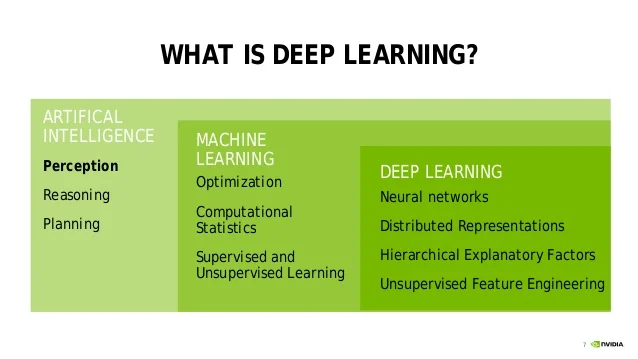

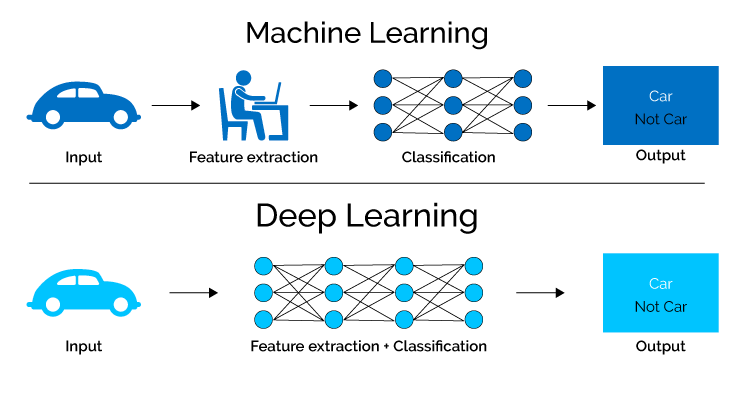

#Composición de una imagen

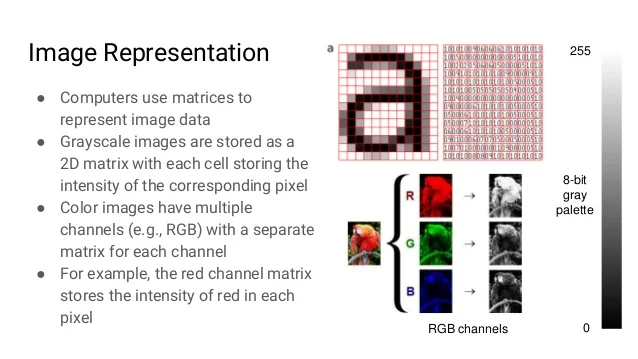

#Composición CNN base

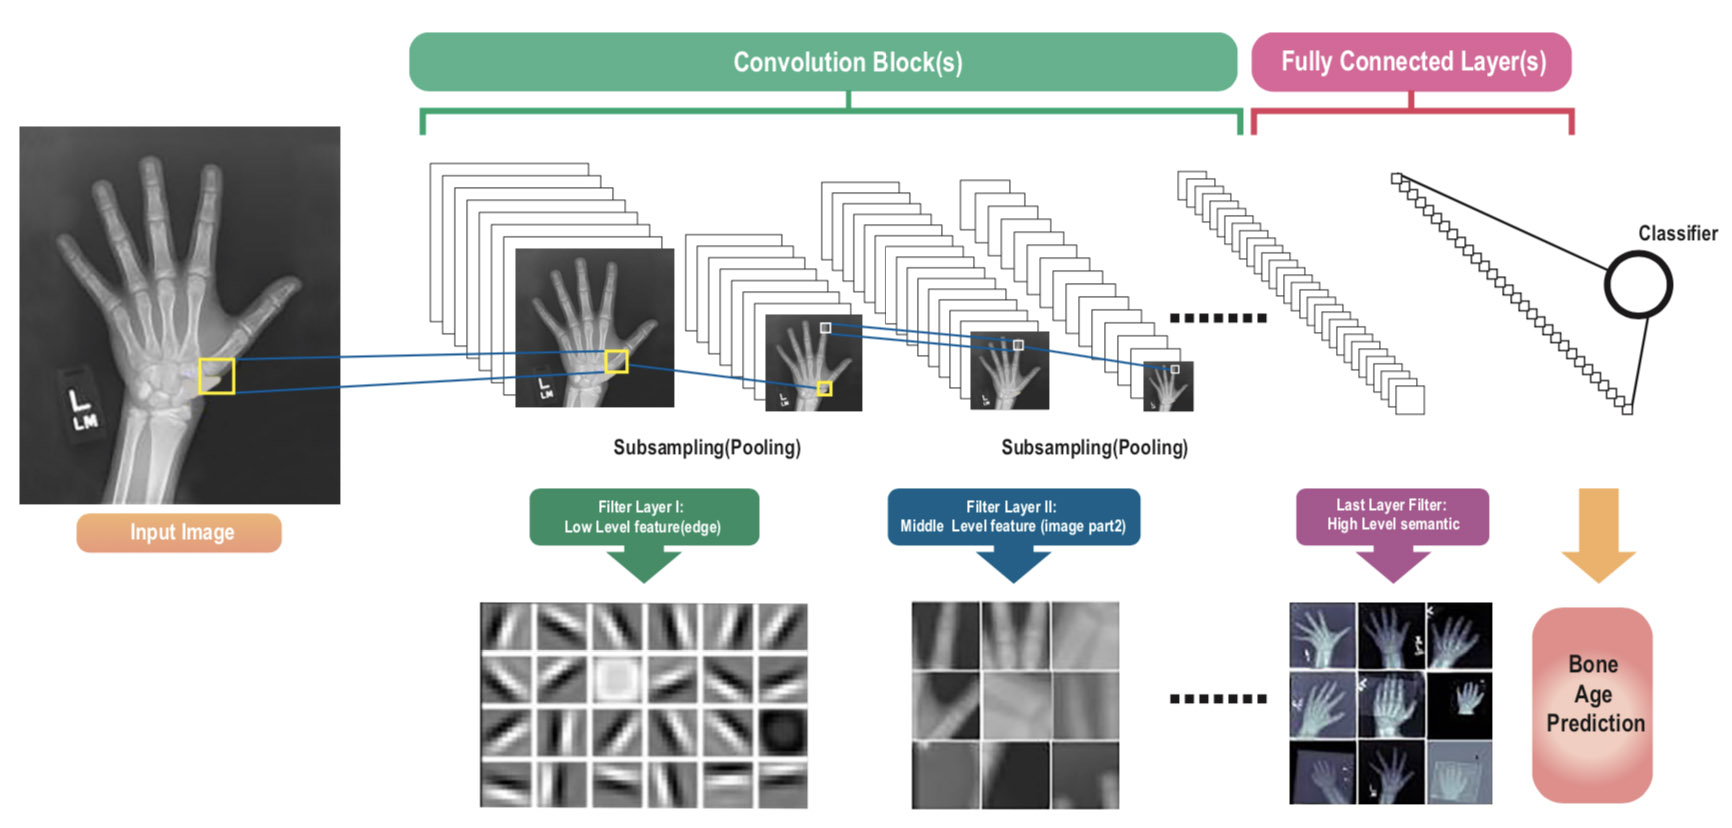

* (Input) Capa de entrada (input)

* (Filtros) N-Capas extractoras de características

* (Aprendizaje) Capas de aprendizaje

* (Classificador) Capa de clasificación

#Transfer learning

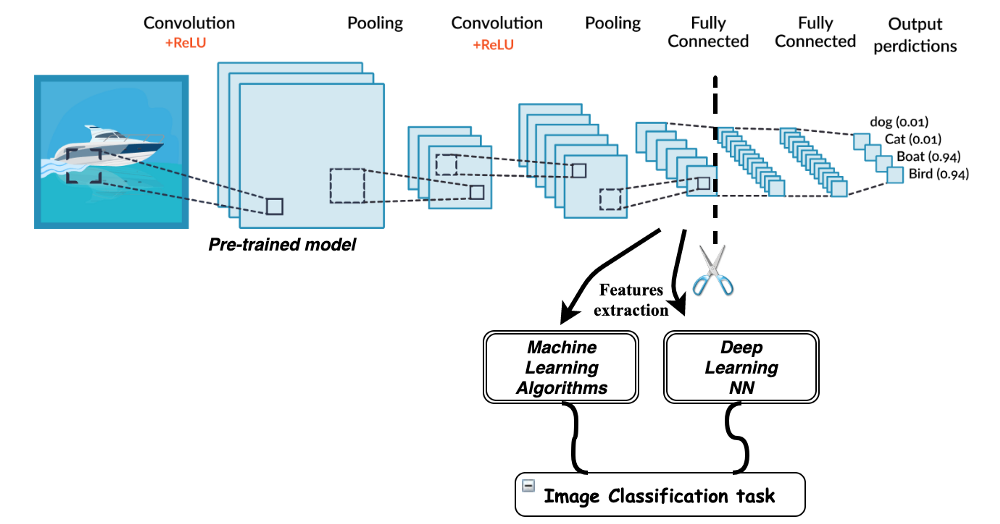

* Partir de un modelo CNN previamente entrenado sobre un dominio

* CORTAR el modelo entrenado por las capas de aprendizaje

* (1) Anexar nuevas capas de aprendizaje y volver entrenar, o (2) extraer caracteristicas de cada imagen

##Calcular similitudes

* Calcularemos similitudes entre los diferentes caras utilizando las características de cada imagen extraída anteriormente.

In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.7 MB/s eta 0:00:00


#1. Importaciones y configuración de parámetros.

In [ ]:
# imports
from keras.applications import vgg16
from keras_preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [ ]:
# Configuración de parámetros

imgs_path = "/content/drive/MyDrive/CSV/FBREF/IMG/file/" # el path de la imagen
imgs_model_width, imgs_model_height = 224, 224 #el ancho y alto de la imagen del modelo

nb_closest_images = 3 # número de las imagenes más similares que se van a mostrar

#2. Cargamos el modelo VGG preentrenado desde Keras
El módulo Keras contiene varios modelos preentrenados que se pueden cargar muy fácilmente.


Para nuestro sistema de recomendación basado en similitud visual, necesitamos cargar una Red Neuronal Convolucional (CNN) que será capaz de interpretar el contenido de la imagen.


En este ejemplo cargaremos el modelo VGG16 entrenado en imagenet, una gran base de datos de imágenes etiquetadas.


Si tomamos todo el modelo, obtendremos una salida que contiene probabilidades de pertenecer a ciertas clases, pero eso no es lo que queremos.


Queremos recuperar toda la información que el modelo pudo obtener en las imágenes.


Para ello, tenemos que eliminar las últimas capas de la CNN que solo se utilizan para las predicciones de clases.

In [ ]:
# Cargamos el modelo
vgg_model = vgg16.VGG16(weights='imagenet')

# Eliminamos las últimas capas para obtener entidades en lugar de predicciones
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# Imprimimos las capas de la CNN
feat_extractor.summary()

553467096/553467096 [==============================] - 17s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
#3. Obtenemos las rutas de las imágenes

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpeg" in x]

print("number of images:",len(files))

number of images: 2754


#4. Alimentamos una imagen en la CNN
Primero observamos qué salida obtenemos al poner una imagen en la CNN.

Los siguientes pasos son:

* cargar la imagen
* preparar la imagen para alimentarla en la CNN
* obtener la salida de CNN que corresponderá a las características de la imagen

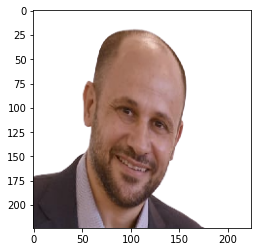

image loaded successfully!


In [ ]:
# cargar la imagen en formato PIL (Python Imaging Library librería gratuita que permite la edición de imágenes directamente desde Python.)
img_test = "/content/drive/MyDrive/CSV/FBREF/IMG/file/foto6.jpeg"
original = load_img(img_test, target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [ ]:
# convertir la imagen PIL a una matriz numpy
# en PIL -  la imagen está en (ancho, alto, canal)
# en Numpy - la imagen está en (ancho, alto, canal)
numpy_image = img_to_array(original)

# convertir las imágenes en formato por lotes
# expand_dims agregará una dimensión adicional a los datos en un eje particular
# queremos que la matriz de entrada a la red sea de la forma (tamaño de lote, altura, anchura, canales)
# Por lo tanto, agregamos la dimensión adicional al eje 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# Preparamos la imagen para el modelo VGG 
processed_image = preprocess_input(image_batch.copy())


image batch size (1, 224, 224, 3)


In [ ]:
# Obtenemos las características extraídas
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 8s 8s/step
features successfully extracted!
number of image features: 4096


array([[0.14791843, 0.19401625, 0.        , ..., 0.        , 0.        ,
        0.48349512]], dtype=float32)

#5. Alimentamos todas las imágenes en la CNN

Pudimos hacer el proceso de extracción de características para una imagen. 

¡Ahora hagámoslo para todas nuestras imágenes!

In [ ]:
# cargar todas las imágenes y prepararlas para alimentarlas en la CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# extraer las características de las imágenes

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape


87/87 [==============================] - 13s 121ms/step
features successfully extracted!


(2754, 4096)

#6. Calcular similitudes de coseno
Ahora que tenemos características para cada imagen, podemos calcular métricas de similitud entre cada par de imágenes. Usaremos aquí la métrica de similitud del coseno.

In [ ]:
# calcular similitudes entre imágenes mediante la medida similitud coseno

cosSimilarities = cosine_similarity(imgs_features)

# almacenar los resultados en un Dataframe de Pandas

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
# len(cos_similarities_df.columns)
cos_similarities_df

,/content/drive/MyDrive/CSV/FBREF/IMG/file/Nahuel Barrios.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Andrés Vombergar.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Ezequiel Cerutti.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Nicolás Blandi.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Augusto Batalla.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Lucas Villalba.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Matías Vera.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Brahian Alemán.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Emanuel Insúa.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Emanuel Olivera.jpeg,...,/content/drive/MyDrive/CSV/FBREF/IMG/file/André Gomes.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Timothy Weah.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Edon Zhegrova.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Leonardo César Jardim.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Mohamed Lamine Bayo.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Leny Yoro.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Alexsandro Ribeiro.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Carlos Baleba.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Yusuf Yazıcı.jpeg,/content/drive/MyDrive/CSV/FBREF/IMG/file/Alan Virginius.jpeg
/content/drive/MyDrive/CSV/FBREF/IMG/file/Nahuel Barrios.jpeg,1.000000,0.881879,0.845965,0.858318,0.859296,0.886613,0.875159,0.811364,0.830609,0.890583,...,0.847908,0.802994,0.886382,0.874415,0.693536,0.777521,0.795340,0.825872,0.858566,0.800913
/content/drive/MyDrive/CSV/FBREF/IMG/file/Andrés Vombergar.jpeg,0.881879,1.000000,0.894391,0.915275,0.925626,0.870704,0.964101,0.791635,0.874263,0.935578,...,0.943799,0.847079,0.959386,0.911623,0.750336,0.836029,0.856405,0.910541,0.852810,0.887783
/content/drive/MyDrive/CSV/FBREF/IMG/file/Ezequiel Cerutti.jpeg,0.845965,0.894391,1.000000,0.932215,0.884493,0.849249,0.892581,0.818848,0.861677,0.891566,...,0.904394,0.883333,0.908917,0.895058,0.751621,0.855785,0.816654,0.897453,0.861876,0.895081
/content/drive/MyDrive/CSV/FBREF/IMG/file/Nicolás Blandi.jpeg,0.858318,0.915275,0.932215,1.000000,0.882359,0.891436,0.921057,0.822207,0.889315,0.916545,...,0.925898,0.843267,0.922457,0.903831,0.739492,0.847078,0.837819,0.911726,0.886010,0.907517
/content/drive/MyDrive/CSV/FBREF/IMG/file/Augusto Batalla.jpeg,0.859296,0.925626,0.884493,0.882359,1.000000,0.826596,0.924513,0.787300,0.877534,0.909805,...,0.914685,0.876383,0.912208,0.882267,0.774650,0.817628,0.883491,0.903458,0.864037,0.887408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/content/drive/MyDrive/CSV/FBREF/IMG/file/Leny Yoro.jpeg,0.777521,0.836029,0.855785,0.847078,0.817628,0.760794,0.852811,0.704259,0.807908,0.830426,...,0.859952,0.812790,0.827206,0.809583,0.655206,1.000000,0.754711,0.856893,0.796457,0.856063
/content/drive/MyDrive/CSV/FBREF/IMG/file/Alexsandro Ribeiro.jpeg,0.795340,0.856405,0.816654,0.837819,0.883491,0.791420,0.876376,0.757739,0.808713,0.856126,...,0.877229,0.805557,0.859041,0.854644,0.724046,0.754711,1.000000,0.847404,0.818593,0.815761
/content/drive/MyDrive/CSV/FBREF/IMG/file/Carlos Baleba.jpeg,0.825872,0.910541,0.897453,0.911726,0.903458,0.826735,0.912063,0.796137,0.885041,0.874391,...,0.910076,0.879793,0.876649,0.866388,0.741153,0.856893,0.847404,1.000000,0.893754,0.949470
/content/drive/MyDrive/CSV/FBREF/IMG/file/Yusuf Yazıcı.jpeg,0.858566,0.852810,0.861876,0.886010,0.864037,0.893248,0.880382,0.806826,0.890830,0.841600,...,0.884423,0.830297,0.849001,0.844924,0.716667,0.796457,0.818593,0.893754,1.000000,0.884589


#7. Recuperar las caras más similares
El paso final es implementar una función que, para cualquier producto dado, devuelva las caras visualmente más similares.

In [ ]:
# función para recuperar las películas más similares visualmente dada a otra 

def retrieve_most_similar_products(given_img):

    plt.title("Original product",color='b')
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    #print("-----------------------------------------------------------------------")
    #print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.title("similarity score :"+str(closest_imgs_scores[i]), color='b')
        plt.imshow(original)
        plt.show()

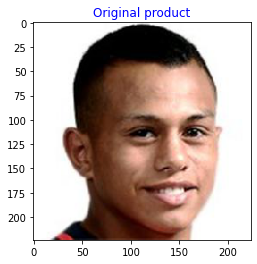

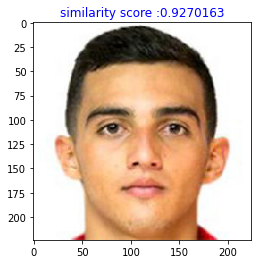

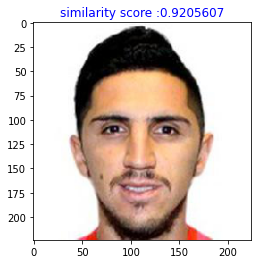

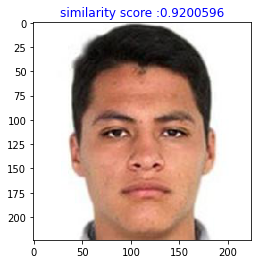

In [ ]:
retrieve_most_similar_products(files[0])

#Mejoras

* Quizás sería interesante considerar más modelos preentrenados o cortar en capas más tempranas.

* Aumentar el tamaño de la muestra

* probar con otras distancias al predecir la similitud.